
## SPARC-4 mini-pipeline tools
***
# <font color='darkblue'>Photometry time series</font> 

This notebook shows an example for obtaining a photometric time series

* Eder Martioli, LNA 20 Jun 2023

<div class="alert alert-block alert-warning">
<b>WARNING:</b> it requires running <b>sp4_sci_image_reduction.ipynb</b> in advance, for the same channel and modes, to generate *_proc.fits reduced files
</div>

In [5]:
import sparc4.product_plots as s4plt
import sparc4.pipeline_lib as s4pipelib
import sparc4.db as s4db
import glob

### Set up work directories and print night log

In [6]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "CR1"

# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 4  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = False

# get SPARC4 pipeline parameters
p = s4pipelib.init_s4_p(datadir=DATADIR,
                        reducedir=REDUCEDDIR,
                        nightdir=NIGHTDIR,
                        channels="{}".format(CHANNEL),
                        print_report=False)

# create database of raw data for reduction
db = s4db.create_db_from_observations(p['filelists'][CHANNEL-1], 
                                      p['DB_KEYS'], 
                                      include_img_statistics=p["INCLUDE_IMG_STATISTICS"], 
                                      include_only_fullframe=p["FULL_FRAMES_ONLY"], 
                                      output=p['s4db_files'][CHANNEL-1])

# detect all detector modes
detector_modes = s4db.get_detector_modes_observed(db, 
                                                  science_only=True,
                                                  detector_keys=p["DETECTOR_MODE_KEYWORDS"])
# get first valid key
mode_key = next(iter(detector_modes))

# set PHOTOMETRIC mode
inst_mode = p['INSTMODE_PHOTOMETRY_KEYVALUE']

# we need the reduce directory 
reduce_ch_dir = p['reduce_directories'][CHANNEL-1]

### User inputs

In [7]:
# Select a short list of apertures to include in the light curve product
catalog_names = p['PHOT_CATALOG_NAMES_TO_INCLUDE']
# Uncomment below to include only the BEST_APERTURES catalog
#catalog_names = ['BEST_APERTURES']
# Uncomment below to include all apertures from 2 to 50 pixels - it takes a long time to conclude
#catalog_names = []

/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/


### Run the main function to produce a photometric time series product

In [8]:
# get list of objects observed in photometric mode
objs = s4db.get_targets_observed(db, 
                                 inst_mode=inst_mode, 
                                 detector_mode=detector_modes[mode_key])

# select object's data 
if OBJECTID != "all" :
    objs = objs[objs['OBJECT'] == OBJECTID]

    
# loop over each object to run the reduction
for k in range(len(objs)) :
    obj = objs[k][0]
    
    # set suffix for output time series filename
    ts_suffix = "{}_s4c{}_{}".format(NIGHTDIR,
                                     p['CHANNELS'][CHANNEL-1] ,
                                     obj.replace(" ",""))    
    
    # get list of science data matching object, detector mode, and inst. mode
    raw_sci_list = s4db.get_file_list(db,
                                      object_id=obj, 
                                      inst_mode=inst_mode, 
                                      obstype=p['OBJECT_OBSTYPE_KEYVALUE'], 
                                      detector_mode=detector_modes[mode_key])
    # input reduced files list
    sci_list = ["{}/{}".format(reduce_ch_dir, os.path.basename(f).replace(".fits","_proc.fits")) for f in raw_sci_list]
    
    # run photometric time series
    phot_ts_product = s4pipelib.phot_time_series(sci_list,
                                                 ts_suffix = ts_suffix,
                                                 reduce_dir = reduce_ch_dir,
                                                 time_key = p['TIME_KEYWORD_IN_PROC'],
                                                 time_format = p['TIME_FORMAT_IN_PROC'],
                                                 catalog_names = catalog_names,
                                                 time_span_for_rms = p['TIME_SPAN_FOR_RMS'],
                                                 force=FORCE)

Packing time series data for catalog: CATALOG_PHOT_AP002
Packing time series data for catalog: CATALOG_PHOT_AP003
Packing time series data for catalog: CATALOG_PHOT_AP004
Packing time series data for catalog: CATALOG_PHOT_AP005
Packing time series data for catalog: CATALOG_PHOT_AP006
Packing time series data for catalog: CATALOG_PHOT_AP007
Packing time series data for catalog: CATALOG_PHOT_AP008
Packing time series data for catalog: CATALOG_PHOT_AP009
Packing time series data for catalog: CATALOG_PHOT_AP010
Packing time series data for catalog: CATALOG_PHOT_AP011
Packing time series data for catalog: CATALOG_PHOT_AP012
Packing time series data for catalog: CATALOG_PHOT_AP013
Packing time series data for catalog: CATALOG_PHOT_AP014
Packing time series data for catalog: CATALOG_PHOT_AP015
Packing time series data for catalog: CATALOG_PHOT_AP016
Packing time series data for catalog: CATALOG_PHOT_AP017
Packing time series data for catalog: CATALOG_PHOT_AP018
Packing time series data for ca

### Plot products

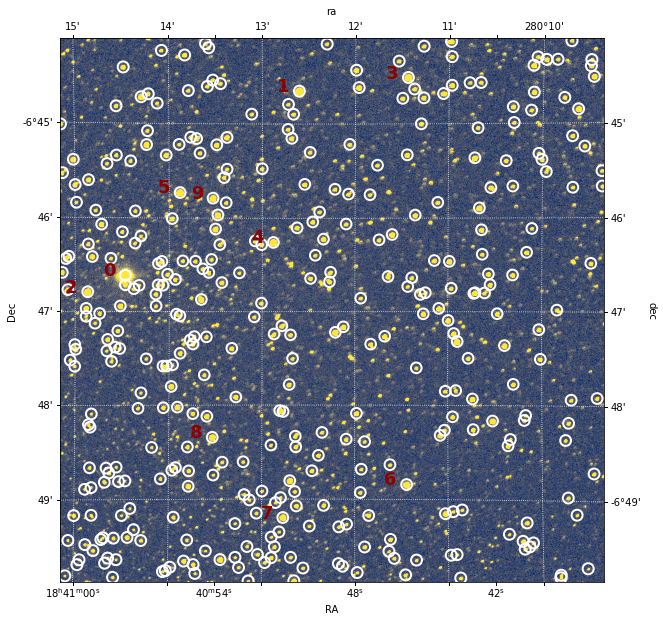

In [9]:
# Plot a science image product to select the target and comparisons
s4plt.plot_sci_frame(sci_list[0], nstars=10, use_sky_coords=True)

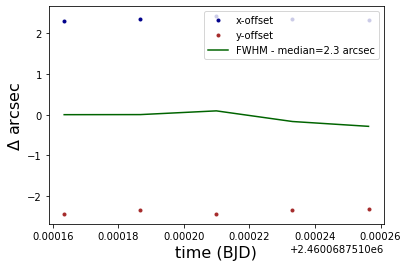

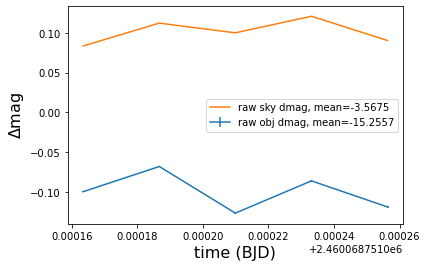

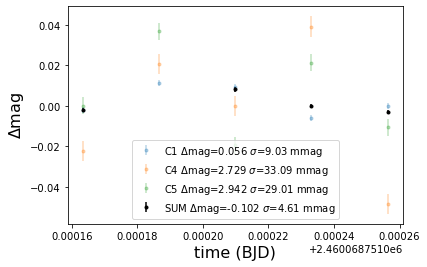

In [10]:
# set target index
target = 0
# set indices for comparison stars
comps = [1,4,5]

# plot time series data
s4plt.plot_light_curve(phot_ts_product, 
                       target=target, 
                       comps=comps, 
                       nsig=3, 
                       plot_coords=True, 
                       plot_rawmags=True, 
                       plot_sum=True, 
                       plot_comps=True, 
                       catalog_name=p['PHOT_REF_CATALOG_NAME'])